In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import daft
import seaborn 
import matplotlib.pyplot as plt



C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


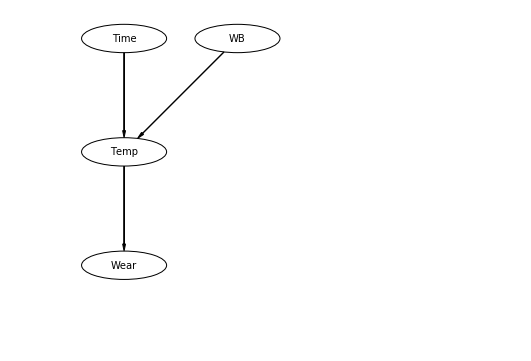

In [2]:
pgm = daft.PGM([9,6],origin=[1, 0.5])
pgm.add_node(daft.Node('Tme','Time',3,6,aspect=3))
pgm.add_node(daft.Node('WB','WB',5,6,aspect=3))
pgm.add_node(daft.Node('Temp','Temp',3,4,aspect=3))
pgm.add_node(daft.Node('Wear','Wear',3,2,aspect=3))
pgm.add_edge('Tme','Temp')
pgm.add_edge('WB','Temp')
pgm.add_edge('Temp','Wear')
pgm.render();


In [3]:
df = pd.read_csv('C:/Users/DESUSAI/Desktop/New folder/Temp.csv',sep=';')
Maxlife = 10000
intialTime=20
df

,Time,Temp,RunningTemp,Wear,Slot
0,1,200,200,16,1
1,1,100,166,13,2
2,1,100,166,12,3
3,1,200,166,20,4
4,1,100,166,15,5


In [4]:
df.describe()

,Time,Temp,RunningTemp,Wear,Slot
count,5.0,5.000000,5.000000,5.000000,5.000000
mean,1.0,140.000000,172.800000,15.200000,3.000000
std,0.0,54.772256,15.205262,3.114482,1.581139
min,1.0,100.000000,166.000000,12.000000,1.000000
25%,1.0,100.000000,166.000000,13.000000,2.000000
50%,1.0,100.000000,166.000000,15.000000,3.000000
75%,1.0,200.000000,166.000000,16.000000,4.000000
max,1.0,200.000000,200.000000,20.000000,5.000000


In [5]:
temp_mean= df.Temp.mean()
temp_mean

140.0

In [6]:
df.skew()

Time           0.000000
Temp           0.608581
RunningTemp    2.236068
Wear           0.933451
Slot           0.000000
dtype: float64

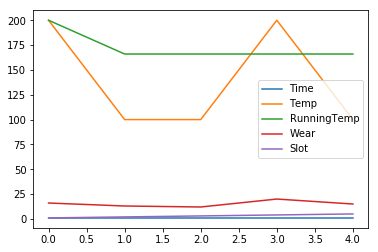

In [7]:
df.plot()
plt.show()

In [8]:
model = pm.Model();
with model:
    time = pm.Normal('time',intialTime)
    temp = pm.Normal('temp',mu=time)
    wear =pm.Normal('wear',mu=temp)
    trace = pm.sample(100000,tune=50000,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████████████████████████████| 150000/150000 [03:25<00:00, 728.69it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009741080>,
      dtype=object)

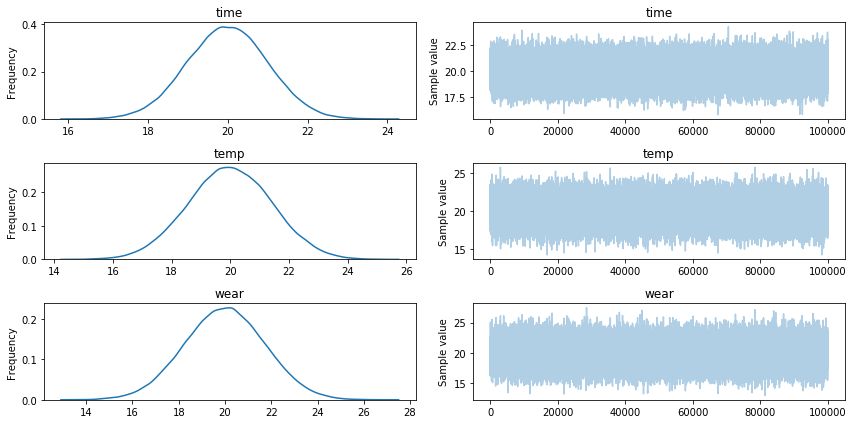

In [9]:
pm.traceplot(trace)

In [10]:
pm.summary(trace)


time:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.993           1.005            0.005            [18.014, 21.943]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  18.019         19.312         19.994         20.672         21.952


temp:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.991           1.423            0.007            [17.191, 22.746]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.211         19.034         19.990         20.961         22.769


wear:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009C7ED30>,
      dtype=object)

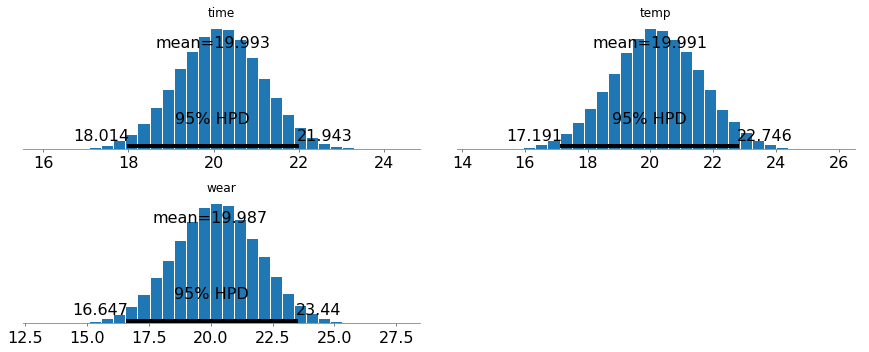

In [11]:
pm.plot_posterior(trace)

In [12]:
pred = pd.DataFrame({
    "Wear": trace["wear"][50000:],
    "Temp": trace["temp"][50000:],
    "Time": trace["time"][50000],
 
})


In [13]:
pred.Wear.mean()


19.974966412468426

In [14]:
pred.Temp.mean()
loopTime = pred.Time.mean()
loopWear = pred.Wear.mean()
loopTemp = pred.Temp.mean()

In [15]:
loopWear

19.974966412468426

In [16]:
loopTemp

19.98188003643802

In [17]:
loopTime

18.287201503848763

In [18]:
for i in range(0,len(df)-1):    
    model2 = pm.Model();    
    with model2:        
        Time2 = pm.Normal('Time2',df.Time[i])
        Temp2 = pm.Normal('Temp2',mu=Time2+loopWear)
        wear2 = pm.Normal('wear2',mu=Temp2+loopWear)
        changedWear= pm.Normal('changedWear',mu=wear2-loopWear)
        trace2 = pm.sample(10000,tune=5000,progressbar=True)    
        globals()["predStep" + str(i)]= pd.DataFrame({
                    "Wear": trace2["wear2"][5000:],
                    "temp": trace2["Temp2"][5000:],
                    "time": trace2["Time2"][5000:],
                    "WearChanged": trace2["changedWear"][5000:]            
        })        
        globals()["predStep" + str(i)].to_csv('C:/Users/DESUSAI/Desktop/New folder/predStep_' + str(i+1)+'.csv', sep=';')
               
        loopTime = globals()["predStep" + str(i)].time.mean()
        loopWear = globals()["predStep" + str(i)].Wear.mean()        
        print(df.Time[i],' sec',round(((Maxlife-loopWear)/Maxlife)*100),'% life is left')        
        
        
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|███████████████████████████████████| 15000/15000 [00:26<00:00, 574.54it/s]


1  sec 100 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|███████████████████████████████████| 15000/15000 [00:26<00:00, 573.26it/s]


1  sec 99 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 15000/15000 [00:26<00:00, 565.15it/s]


1  sec 98 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|███████████████████████████████████| 15000/15000 [00:25<00:00, 580.02it/s]


1  sec 97 % life is left


In [19]:
type(predStep0)

pandas.core.frame.DataFrame

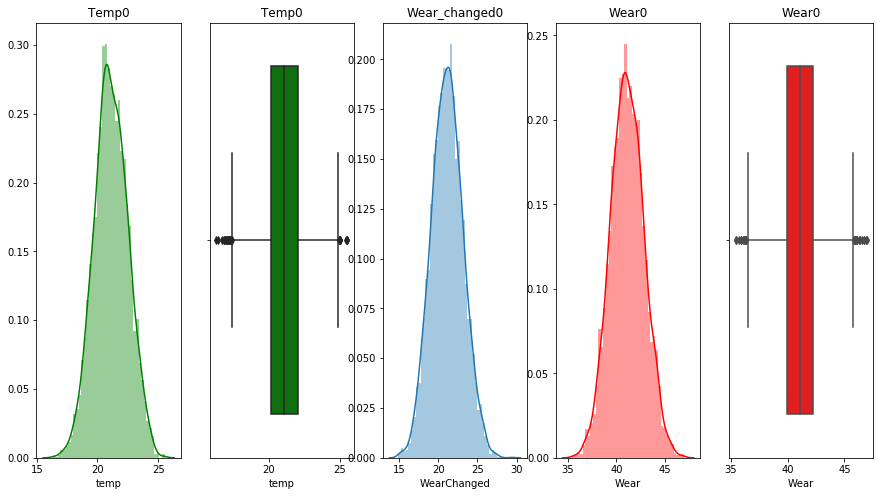

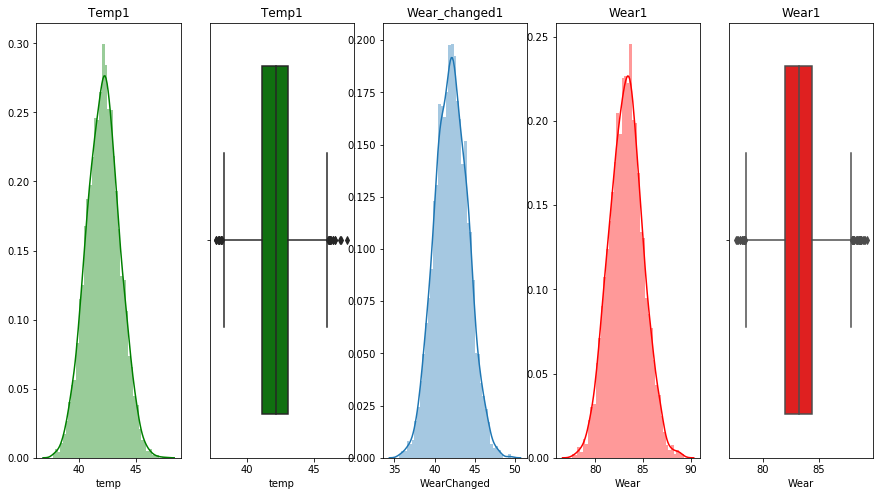

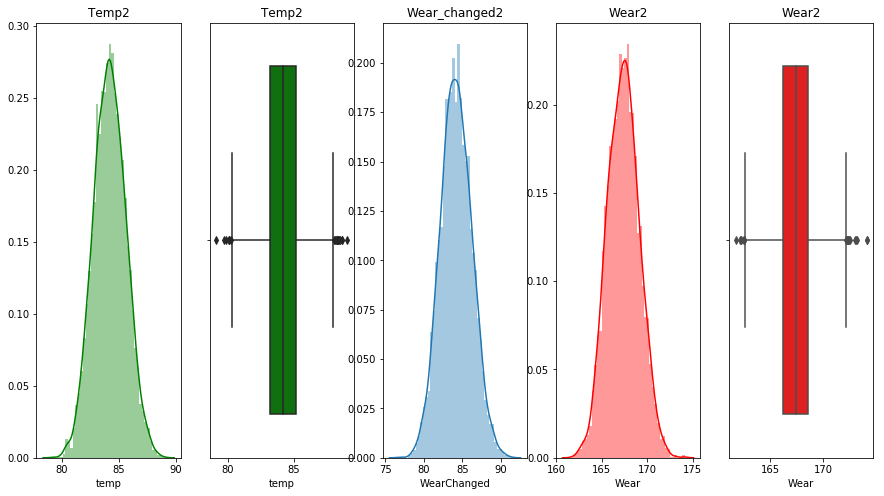

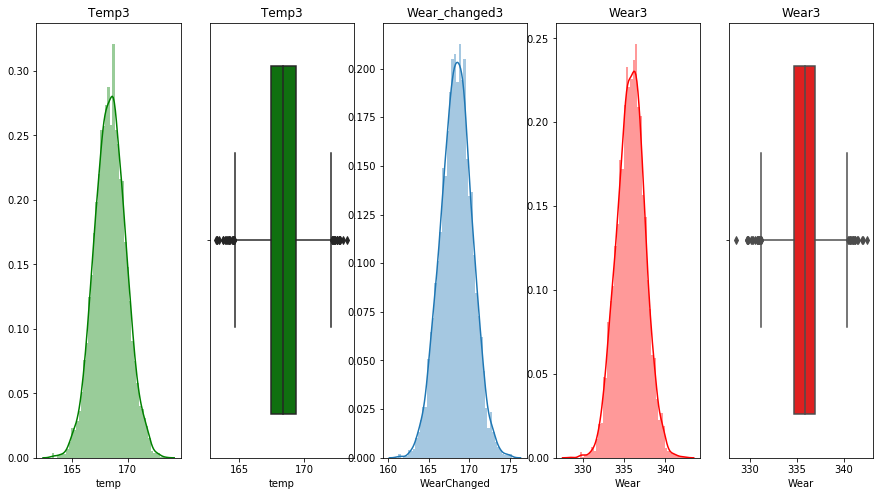

In [20]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,5)
    fig.set_figheight(8)
    fig.set_figwidth(15)    
    #plt.figure(i)
    #plt.grid(True)
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0],color='green').set_title("Temp"+str(i))
    seaborn.boxplot(globals()["predStep" + str(i)].temp,ax=ax[1],color='green').set_title("Temp"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].WearChanged,ax=ax[2]).set_title("Wear_changed"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].Wear,ax=ax[3],color='r').set_title("Wear"+str(i))
    seaborn.boxplot(globals()["predStep" + str(i)].Wear,ax=ax[4],color='r').set_title("Wear"+str(i))
    
    
    #seaborn.set_axis_labels("WearChanged","temp");
    #seaborn.distplot(globals()["predStep" + str(i)].Wear, ax=ax[1]).set_title("Wear"+str(i))    


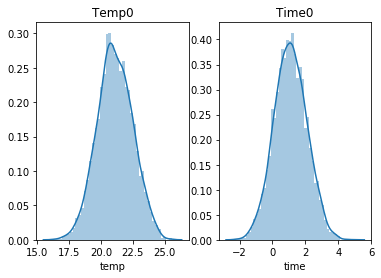

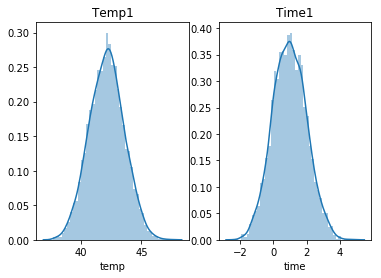

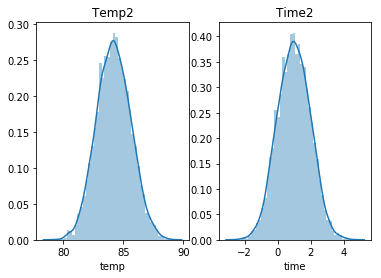

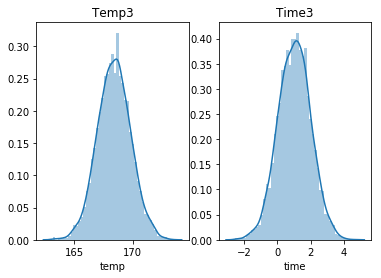

In [21]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,2)
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0]).set_title("Temp"+str(i))
    seaborn.distplot(globals()["predStep" + str(i)].time,ax=ax[1]).set_title("Time"+str(i))

    #seaborn.factorplot("Wear", data=globals()["predStep" + str(i)],ax=ax[1], kind="box")

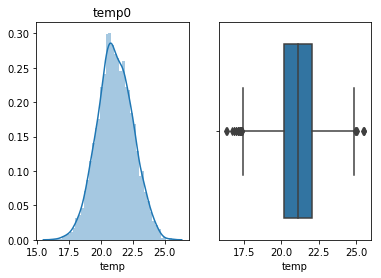

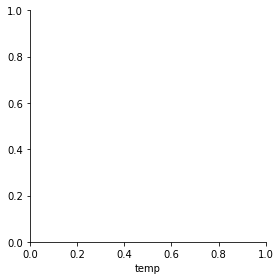

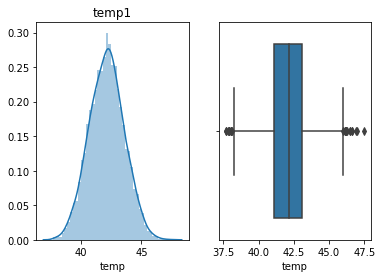

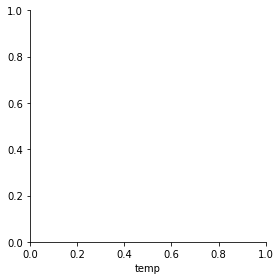

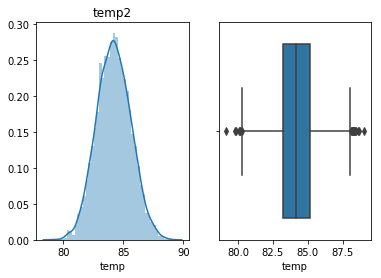

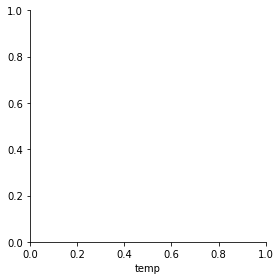

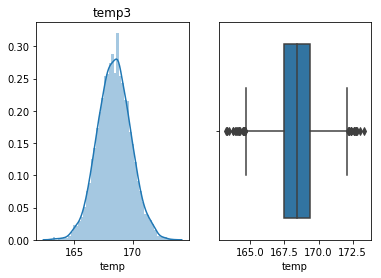

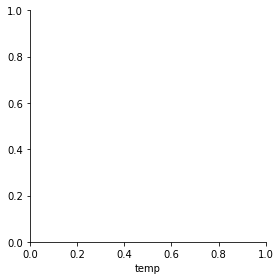

In [22]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,2)
    
    seaborn.distplot(globals()["predStep" + str(i)].temp,ax=ax[0]).set_title("temp"+str(i))    
    seaborn.factorplot("temp", data=globals()["predStep" + str(i)],ax=ax[1], kind="box") 
    

In [23]:
cdf = pd.read_csv("C:/Users/DESUSAI/Desktop/New folder/predStep_1.csv",sep=';')
cdf

,Unnamed: 0,Wear,WearChanged,temp,time
0,0,39.846840,20.683698,19.255522,0.184619
1,1,41.564339,22.138508,21.901464,0.297306
2,2,41.438031,21.450646,20.010253,0.383442
3,3,40.189564,20.601061,20.481417,0.593667
4,4,40.077167,20.284828,20.886589,0.900176
5,5,39.939916,20.636284,18.939478,-0.809705
6,6,37.968048,18.629282,20.090887,0.963210
7,7,38.208756,16.977057,18.451608,0.114047
8,8,40.520852,19.966516,19.341253,0.345840
9,9,39.869808,21.025455,20.311584,0.741911
